In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, sparse
import pandas as pd
import time

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map, show
from nilearn.masking import intersect_masks
from sklearn.metrics import r2_score

from functional_alignment.hyperalignment import hyperalign, zscore, Hyperalignment
from functional_alignment.ridge_hyperalignment import RidgeHyperalignment
from functional_alignment.ridge_cv import RidgeCV
from functional_alignment.piecewise_alignment import PieceWiseAlignment
from functional_alignment.rrr_cv import RRRCV
from functional_alignment.reduced_rank_regression import RRR

In [4]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

## Fetching

In [5]:
N = 4 # number of subjects

In [6]:
haxby_dataset = datasets.fetch_haxby('/Users/thomasbazeille/Downloads',subjects=N)

In [4]:
print('Mask nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' % haxby_dataset.func[0])
#print haxby_dataset.description

Mask nifti image (3D) is located at: /Users/thomasbazeille/Downloads/haxby2001/mask.nii.gz
Functional nifti image (4D) is located at: /Users/thomasbazeille/Downloads/haxby2001/subj1/bold.nii.gz


## Splitting into train and test set

In [7]:
train_session = []
test_session = []
for i in range(N):
    labels = pd.read_csv(haxby_dataset.session_target[i], sep=" ")
    condition_mask = labels['labels'] != b'rest'
    train_chunks =  labels['chunks']<= 5
    test_chunks = labels['chunks'] > 5

    train_labels = labels[condition_mask&train_chunks].sort_values(by=['chunks', 'labels'])
    test_labels = labels[condition_mask&test_chunks].sort_values(by=['chunks', 'labels'])
    train_session.append(train_labels)
    test_session.append(test_labels)
    
print("example : train_session_1 , train_session_2 , test_session_1 , test_session_2")
display_side_by_side(train_session[0],train_session[1],test_session[0],test_session[1])

example : train_session_1 , train_session_2 , test_session_1 , test_session_2


labels 
 chunks 
 
 
 
 
 92 
 bottle 
 0 
 
 
 93 
 bottle 
 0 
 
 
 94 
 bottle 
 0 
 
 
 95 
 bottle 
 0 
 
 
 96 
 bottle 
 0 
 
 
 97 
 bottle 
 0 
 
 
 98 
 bottle 
 0 
 
 
 99 
 bottle 
 0 
 
 
 100 
 bottle 
 0 
 
 
 35 
 cat 
 0 
 
 
 36 
 cat 
 0 
 
 
 37 
 cat 
 0 
 
 
 38 
 cat 
 0 
 
 
 39 
 cat 
 0 
 
 
 40 
 cat 
 0 
 
 
 41 
 cat 
 0 
 
 
 42 
 cat 
 0 
 
 
 43 
 cat 
 0 
 
 
 106 
 chair 
 0 
 
 
 107 
 chair 
 0 
 
 
 108 
 chair 
 0 
 
 
 109 
 chair 
 0 
 
 
 110 
 chair 
 0 
 
 
 111 
 chair 
 0 
 
 
 112 
 chair 
 0 
 
 
 113 
 chair 
 0 
 
 
 114 
 chair 
 0 
 
 
 21 
 face 
 0 
 
 
 22 
 face 
 0 
 
 
 23 
 face 
 0 
 
 
 24 
 face 
 0 
 
 
 25 
 face 
 0 
 
 
 26 
 face 
 0 
 
 
 27 
 face 
 0 
 
 
 28 
 face 
 0 
 
 
 29 
 face 
 0 
 
 
 63 
 house 
 0 
 
 
 64 
 house 
 0 
 
 
 65 
 house 
 0 
 
 
 66 
 house 
 0 
 
 
 67 
 house 
 0 
 
 
 68 
 house 
 0 
 
 
 69 
 house 
 0 
 
 
 70 
 house 
 0 
 
 
 71 
 house 
 0 
 
 
 6 
 scissors 
 0 
 
 
 7 
 scissors 
 0 
 
 
 8 
 scissors 
 0 
 
 
 9 
 scissors 
 0 
 
 
 10 
 scissors 
 0 
 
 
 11 
 scissors 
 0 
 
 
 12 
 scissors 
 0 
 
 
 13 
 scissors 
 0 
 
 
 14 
 scissors 
 0 
 
 
 78 
 scrambledpix 
 0 
 
 
 79 
 scrambledpix 
 0 
 
 
 80 
 scrambledpix 
 0 
 
 
 81 
 scrambledpix 
 0 
 
 
 82 
 scrambledpix 
 0 
 
 
 83 
 scrambledpix 
 0 
 
 
 84 
 scrambledpix 
 0 
 
 
 85 
 scrambledpix 
 0 
 
 
 86 
 scrambledpix 
 0 
 
 
 49 
 shoe 
 0 
 
 
 50 
 shoe 
 0 
 
 
 51 
 shoe 
 0 
 
 
 52 
 shoe 
 0 
 
 
 53 
 shoe 
 0 
 
 
 54 
 shoe 
 0 
 
 
 55 
 shoe 
 0 
 
 
 56 
 shoe 
 0 
 
 
 57 
 shoe 
 0 
 
 
 199 
 bottle 
 1 
 
 
 200 
 bottle 
 1 
 
 
 201 
 bottle 
 1 
 
 
 202 
 bottle 
 1 
 
 
 203 
 bottle 
 1 
 
 
 204 
 bottle 
 1 
 
 
 205 
 bottle 
 1 
 
 
 206 
 bottle 
 1 
 
 
 207 
 bottle 
 1 
 
 
 142 
 cat 
 1 
 
 
 143 
 cat 
 1 
 
 
 144 
 cat 
 1 
 
 
 145 
 cat 
 1 
 
 
 146 
 cat 
 1 
 
 
 147 
 cat 
 1 
 
 
 148 
 cat 
 1 
 
 
 149 
 cat 
 1 
 
 
 150 
 cat 
 1 
 
 
 170 
 chair 
 1 
 
 
 171 
 chair 
 1 
 
 
 172 
 chair 
 1 
 
 
 173 
 chair 
 1 
 
 
 174 
 chair 
 1 
 
 
 175 
 chair 
 1 
 
 
 176 
 chair 
 1 
 
 
 177 
 chair 
 1 
 
 
 178 
 chair 
 1 
 
 
 127 
 face 
 1 
 
 
 128 
 face 
 1 
 
 
 129 
 face 
 1 
 
 
 130 
 face 
 1 
 
 
 131 
 face 
 1 
 
 
 132 
 face 
 1 
 
 
 133 
 face 
 1 
 
 
 134 
 face 
 1 
 
 
 135 
 face 
 1 
 
 
 213 
 house 
 1 
 
 
 214 
 house 
 1 
 
 
 215 
 house 
 1 
 
 
 216 
 house 
 1 
 
 
 217 
 house 
 1 
 
 
 218 
 house 
 1 
 
 
 219 
 house 
 1 
 
 
 220 
 house 
 1 
 
 
 221 
 house 
 1 
 
 
 184 
 scissors 
 1 
 
 
 185 
 scissors 
 1 
 
 
 186 
 scissors 
 1 
 
 
 187 
 scissors 
 1 
 
 
 188 
 scissors 
 1 
 
 
 189 
 scissors 
 1 
 
 
 190 
 scissors 
 1 
 
 
 191 
 scissors 
 1 
 
 
 192 
 scissors 
 1 
 
 
 227 
 scrambledpix 
 1 
 
 
 228 
 scrambledpix 
 1 
 
 
 229 
 scrambledpix 
 1 
 
 
 230 
 scrambledpix 
 1 
 
 
 231 
 scrambledpix 
 1 
 
 
 232 
 scrambledpix 
 1 
 
 
 233 
 scrambledpix 
 1 
 
 
 234 
 scrambledpix 
 1 
 
 
 235 
 scrambledpix 
 1 
 
 
 156 
 shoe 
 1 
 
 
 157 
 shoe 
 1 
 
 
 158 
 shoe 
 1 
 
 
 159 
 shoe 
 1 
 
 
 160 
 shoe 
 1 
 
 
 161 
 shoe 
 1 
 
 
 162 
 shoe 
 1 
 
 
 163 
 shoe 
 1 
 
 
 164 
 shoe 
 1 
 
 
 305 
 bottle 
 2 
 
 
 306 
 bottle 
 2 
 
 
 307 
 bottle 
 2 
 
 
 308 
 bottle 
 2 
 
 
 309 
 bottle 
 2 
 
 
 310 
 bottle 
 2 
 
 
 311 
 bottle 
 2 
 
 
 312 
 bottle 
 2 
 
 
 313 
 bottle 
 2 
 
 
 248 
 cat 
 2 
 
 
 249 
 cat 
 2 
 
 
 250 
 cat 
 2 
 
 
 251 
 cat 
 2 
 
 
 252 
 cat 
 2 
 
 
 253 
 cat 
 2 
 
 
 254 
 cat 
 2 
 
 
 255 
 cat 
 2 
 
 
 256 
 cat 
 2 
 
 
 291 
 chair 
 2 
 
 
 292 
 chair 
 2 
 
 
 293 
 chair 
 2 
 
 
 294 
 chair 
 2 
 
 
 295 
 chair 
 2 
 
 
 296 
 chair 
 2 
 
 
 297 
 chair 
 2 
 
 
 298 
 chair 
 2 
 
 
 299 
 chair 
 2 
 
 
 334 
 face 
 2 
 
 
 335 
 face 
 2 
 
 
 336 
 face 
 2 
 
 
 337 
 face 
 2 
 
 
 338 
 face 
 2 
 
 
 339 
 face 
 2 
 
 
 340 
 face 
 2 
 
 
 341 
 face 
 2

## Compare the masks

0 (1452, 577)
1 (1452, 464)
2 (1452, 307)
3 (1452, 675)


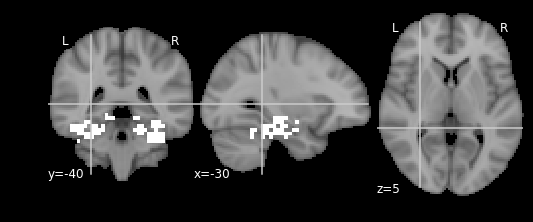

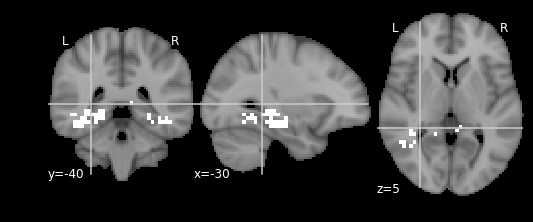

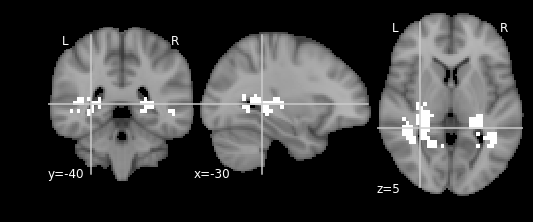

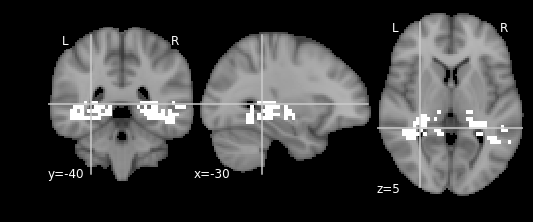

In [19]:
cut_coords = (-30,-40,5)

for i in range(N):
    X_file = haxby_dataset.func[i]
    vt_mask = haxby_dataset.mask_vt[i]
    plot_stat_map(vt_mask,cut_coords=cut_coords,black_bg=True,colorbar=False)
    vt_masker = NiftiMasker(vt_mask, smoothing_fwhm=4,
            standardize=True, memory="nilearn_cache", memory_level=1)
    X_vt = vt_masker.fit_transform(X_file)
    print i,np.shape(X_vt)

## Find the union of all masks

Applying the general mask and separating the data between train and test buckets :

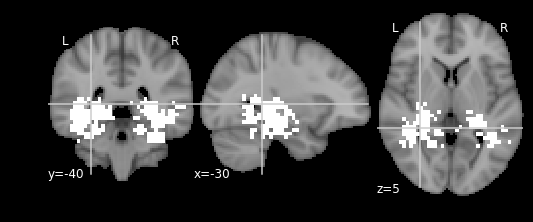

In [20]:
# general_mask_filename = haxby_dataset.mask
vt_mask_list = []
for i in range(N):
    vt_mask_list.append(haxby_dataset.mask_vt[i])

union_mask = intersect_masks(vt_mask_list, threshold=0, connected=False)
plot_stat_map(union_mask, cut_coords=cut_coords,black_bg=True,colorbar=False)

## Apply it to all data

In [27]:
masker = NiftiMasker(union_mask, smoothing_fwhm=0,
            standardize=True, memory="nilearn_cache", memory_level=1)

X_train = []
X_test = []

for i in range(N): 
    X = masker.fit_transform(haxby_dataset.func[i])
    X_train.append(X[train_session[i].index])
    X_test.append(X[test_session[i].index])
    
print np.shape(X_train)
print(np.shape(X_train[0]))
print type(X_train)
print type(X_train[0])

(4, 432, 1624)
(432, 1624)
<type 'list'>
<type 'numpy.ndarray'>


## Test of union mask hyperalignement

bug de hyperalign par moment, sqrt
shape of R (n_samples, n_samples)
bug de hyperalign on Haxby subject 3, gives R(n_voxels,n_voxels) instead of R(n_samples,n_samples) solve the dual but for an unknown reason.
Same for Hyperalignement class, bug






In [30]:
X_train_T = []
X_test_T = []
for i in range(N):
    X_train_T.append(X_train[i].T)
    X_test_T.append(X_test[i].T)
print np.shape(X_train_T)
print(X_train_T[1])
R = Hyperalignment()
R.fit(X_train_T[0],X_train_T[1])



(4, 1624, 432)
[[-0.97850585 -0.70458776 -1.70895422 ...,  1.41827774  1.32697177
   1.16718614]
 [-0.1715745  -0.11962631 -1.73002028 ...,  0.52106804  0.17474675
  -0.05036206]
 [ 0.44294971  1.17548108  1.04229355 ...,  0.24316843 -0.02320661
  -0.15639414]
 ..., 
 [-1.23043633 -1.45595717 -1.57739151 ...,  0.12268902 -0.08548409
   0.12268902]
 [ 0.06061292  0.2883231   0.21241972 ..., -0.62251765 -0.88817954
  -1.34359992]
 [ 0.7599082   0.63250619  0.67497355 ...,  0.78114182  1.14211404
   1.20581496]]


IndexError: tuple index out of range

In [18]:
 X_ = [x - x.mean(axis=1, keepdims=True) for x in X_train]
print np.shape(X_)

(4, 1624, 432)


In [ ]:
# Ridge Hyperalignement

In [ ]:
R_ridge = RidgeHyperalignment()
R_ridge.fit(X_1_train,X_2_train)
train_pred = R_ridge.transform(X_1_train)
train_precision = np.linalg.norm(train_pred-X_2_train,axis=(0,1))/np.linalg.norm(X_1_train-X_2_train,axis=(0,1))
print train_precision

In [ ]:
X_2_pred = R_ridge.transform(X_1_test)
test_precision = np.linalg.norm(X_2_pred-X_2_test,axis=(0,1))/np.linalg.norm(X_1_test-X_2_test,axis=(0,1))
print test_precision

In [ ]:
plt.imshow(R_ridge.b.dot(R_ridge.a));
plt.colorbar()
plt.show()

In [ ]:
# Ridge CV

In [ ]:
ridge_estim = RidgeCV(alphas=(0.1,1,10,100,1000,10000,100000,500000,1000000),n_splits=4)
ridge_estim.fit(X_1_train,X_2_train)
print ridge_estim.alpha

In [ ]:
X_2_pred = ridge_estim.transform(X_1_test)
test_precision = np.linalg.norm(X_2_pred-X_2_test,axis=(0,1))/np.linalg.norm(X_1_test-X_2_test,axis=(0,1))
print test_precision

In [ ]:
# Reduced Rank Regression

In [ ]:
start_time = time.time()
rrr_estim = RRR()
rrr_estim.fit(X_1_train,X_2_train)
X_2_pred = rrr_estim.predict(X_1_test)
test_precision = np.linalg.norm(X_2_pred-X_2_test,axis=(0,1))/np.linalg.norm(X_1_test-X_2_test,axis=(0,1))
print test_precision
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# Reduced Rank Regression cv

In [ ]:
rrr_cv_estim = rrr_cv.RRRCV(alphas=[0.1,1,10], ks=[0.1,1,10], n_splits=4)
rrr_cv_estim.fit(X_1_train,X_2_train)
X_2_pred = rrr_cv_estim.predict(X_1_test)
test_precision = np.linalg.norm(X_2_pred-X_2_test,axis=(0,1))/np.linalg.norm(X_1_test-X_2_test,axis=(0,1))
print test_precision

# Parcellation based alignement

In [ ]:
Im_1_train = masker.inverse_transform(X_1_train)
Im_2_train = masker.inverse_transform(X_2_train)
Im_1_test = masker.inverse_transform(X_1_test)

In [ ]:
a = PieceWiseAlignment(n_pieces=1000, method="mean", perturbation=False, mask=masker,detrend=True)
a.fit(Im_1_train,Im_2_train)
#labels,fit,infos = piecewise_alignment.fit_one_parcellation(X_1_train, X_2_train, mask=masker, n_pieces=200, method='ward',mem=Memory(cachedir=None))

In [ ]:
b = a.transform(Im_1_test)

In [ ]:
X_1_test_piecewise = masker.fit_transform(b)
test_precision = np.linalg.norm(X_1_test_piecewise-X_2_test,axis=(0,1))/np.linalg.norm(X_1_test-X_2_test,axis=(0,1))
print test_precision